# Bottom DO

A simple notebook to generate dissolved oxygen plots for the bottom layer, either for a single run or to compare multiple runs side-by-side.

## Parameters

* `do_data_cdf`: The NetCDF file containing DO results. This is generated using one of the extraction notebooks or [do_rawcdf_extraction.py](do_rawcdf_extraction.py).
* `start_date`: A date string to use as day 0 when formatting plot time axes.
* `domain_out_shp`: The shapefile that defines the node areas in the analysis domain. This is generated with [ProcessGrid.ipynb](ProcessGrid).
* `ssm_full_union_shp`: The shapefile that defines the complete SSM model grid as a single polygon. This is generated with [ProcessGrid.ipynb](ProcessGrid) and is only used to depict the water boundary/geography.
* `sites`: A dict of node numbers and corresponding labels for locations that get dedicated timeseries plots of bottom DO.

In [1]:
do_data_cdf = "model_results/bottom do 2008.nc"
do_variables = ('existing', 'reference')
start_date = "2008-01-01"
domain_out_shp = "gis/ssm filled domain nodes.shp"
ssm_full_union_shp = "gis/ssm full union.shp"

sites = {
    7786: "Admiralty Inlet South",
    12166: "East Passage",
    15490: "Budd Inlet",
    13789: "Lynch Cove"
}

from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
#%matplotlib widget
%matplotlib inline

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), node(6120)
    variables(dimensions): int32 node(node), float32 time(time), float32 existing(time, node), float32 reference(time, node)
    groups: 

In [3]:
domain = gpd.read_file(domain_out_shp)
domain.set_index('node_id', inplace=True)
domain.head()

,depth,geometry
node_id,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5..."
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5..."


In [4]:
full_union = gpd.read_file(ssm_full_union_shp)
full_union.head()

,FID,geometry
0,0,"POLYGON ((528686.964 5024948.030, 528447.309 5..."


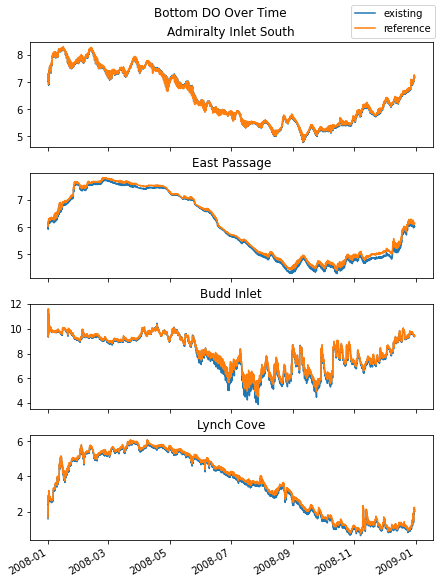

In [5]:
fig, axs = plt.subplots(len(sites), 1, constrained_layout=True, figsize=(6, len(sites)*2))
times = do_data['time'][:]
dates = pd.Timestamp(start_date) + pd.to_timedelta(times, 'd')
for ax,(n,s) in zip(axs, sites.items()):
    idx = np.nonzero(do_data['node'][:] == n)[0]
    for v in do_variables:
        ax.plot(dates, do_data[v][:,idx], label=v)
    ax.set(title=s)

# Implement autofmt_xdate() by hand because it would break subplot title placement
for ax in axs[:-1]:
    ax.set_xticklabels(())
for l in axs[-1].get_xticklabels():
    l.set_ha('right')
    l.set_rotation(30)
fig.suptitle("Bottom DO Over Time")
# https://stackoverflow.com/a/46921590/413862
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

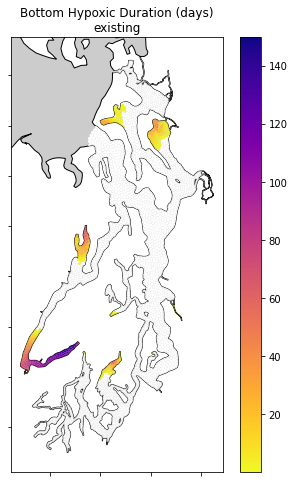

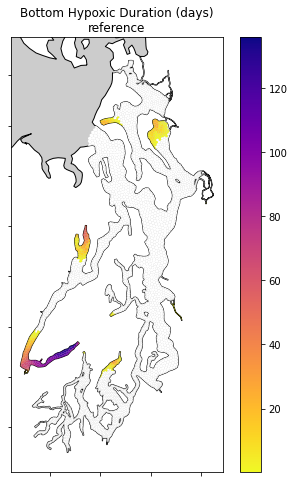

In [6]:
mycmap = cm.get_cmap("plasma_r").copy()
mycmap.set_under('white', 1)

def do_plot(vals, title, ax=None, **kwargs):
    copy = domain.copy()
    copy['values'] = vals
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8))
    p = copy.plot('values', ax=ax, markersize=1, legend=True, zorder=2, **kwargs)
    # Save the axes boundaries so we can restore them after plotting the full model boundary
    xmin, xmax, ymin, ymax = p.axis()
    full_union.plot(ax=ax, facecolor='#ccc', edgecolors='black', zorder=1)
    ax.set(title=title, ybound=(ymin, ymax), xbound=(xmin, xmax), xticklabels=(), yticklabels=())
    return copy

for v in do_variables:
    data = do_data[v][:]
    hypoxic_durations = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        # FIXME assumes hourly output!
        hypoxic_durations[i] = np.count_nonzero(data[:,i] < 2) / 24
    norm = colors.Normalize(vmin=0.1, vmax=hypoxic_durations.max())
    do_plot(hypoxic_durations, "Bottom Hypoxic Duration (days)\n{0}".format(v), cmap=mycmap, norm=norm)

existing: Max hypoxic area 109.69 km2 on 2008-10-01
reference: Max hypoxic area 87.74 km2 on 2008-12-23


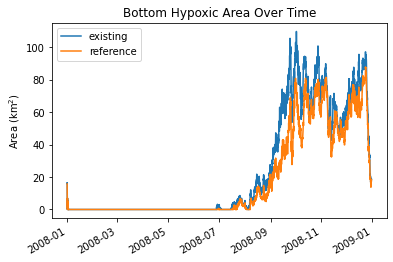

In [7]:
# Representative areas of each node
areas = domain.loc[do_data['node'][:].data].area

fig, ax = plt.subplots()
for v in do_variables:
    data = do_data[v][:]
    hypoxic_area = np.zeros(data.shape[0])
    for t in range(data.shape[0]):
        hypoxic_area[t] = areas.loc[data[t,:] < 2].sum() / 1000000
    ax.plot(dates, hypoxic_area, label=v)
    ax.set(title="Bottom Hypoxic Area Over Time", ylabel="Area (km$^2$)")
    print("{0}: Max hypoxic area {1:.2f} km2 on {2}".format(v, hypoxic_area.max(), dates[hypoxic_area.argmax()].date()))
fig.autofmt_xdate()
ax.legend()